# Bootstrap estimation

This notebook contains the some code examples that explain how Python can help us better understand probability and statistics concepts. 

The benefit of computational notebooks is you can play with the code examples interactively. To run a code cell, press the play button in the menu bar, or use the keyboard shortcut **SHIFT+ENTER**.

### Notebook setup

In [1]:
# Install stats library
%pip install --quiet ministats 


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Figures setup
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    style="whitegrid",
    rc={'figure.figsize': (4, 3)},
)
# High-resolution figures please
%config InlineBackend.figure_format = 'retina'

def savefig(fig, filename, **kwargs):
    fig.tight_layout(**kwargs)
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)

<Figure size 640x480 with 0 Axes>

## Introduction

In this notebook, I want to introduce you to some core statistics concepts from a computational perspective. By writing simple Python code (mostly `for` loops), you can understand some core ideas of statistics. If you're not familiar with Python at all, I recommend you read [Part 1 of the blog post series](https://minireference.com/blog/python-for-stats/) and the associated [notebook](./python_for_stats.ipynb) first.

**TL;DR** My main realization from working on the STATS book is that the hands-on computational approach to statistical calculations makes learning concepts much more straightforward, as compared to the classical way of teaching which is based on formulas and procedures. This is why we'll present the key ideas using Python code and visualizations, which should be accessible to most readers.

The statistical analyses examples in this notebook are taken from the textbook [No Bullshit Guide to Stats](https://nobsstats.com/), which you can check out if you want to learn more statistics.

Let's start with what this is all about…

### The modern statistics curriculum

Many statistics techniques of the classical curriculum were developed in a time with limited computation capabilities. Using a computational approach makes many  "hard" topics in statistics much easier to understand. There is a growing movement in statistics education called "modern statistics" that puts the focus on using computers for statistical calculations.

The two techniques from the modern statistics curriculum we'll discuss in this blog post are:
- **Simulation**: Direct computational approach for doing probability calculations by simulating tens of thousands of samples from the relevant population. We can then calculate relevant quantities directly from the samples instead of using math formulas. 
- **Resampling methods**: This is an umbrella term for various clever techniques that reuse data from observed sample to simulate the variability in the population. We'll talk about bootstrap estimation in this notebook.

The simulation and resampling methods are computationally expensive, but they apply for **any distribution** and allows us to compute **any quantity of interest**—not just quantities for which statisticians have found formulas.

### Bootstrap estimation

The bootstrap procedure is a powerful technique for estimating the variability of any estimator. 

Computationally, the bootstrap method involves a simple `for`-loop that repeatedly generates new samples from the existing data. This approach to uncertainty estimation is very intuitive, and it allows us to reach a deeper understanding than the classical formulas-based approximation methods that are taught in most STATS101 courses.

## Example data analysis scenario

We'll use an example to ground the discussions in the rest of the notebook. 

### IQ scores population

This population is unknown to the person doing the analysis,
but for the sake of graphs, we will pretend we're omniscient and know what it is.

In [3]:
from scipy.stats import norm

muX = 108.25
rvX = norm(loc=muX, scale=15)
print(f"N(mu={muX},sigma=15)")

N(mu=108.25,sigma=15)


To avoid talking about models in the presentation,
we make the population a concrete set of 1000 individual IQ scores.

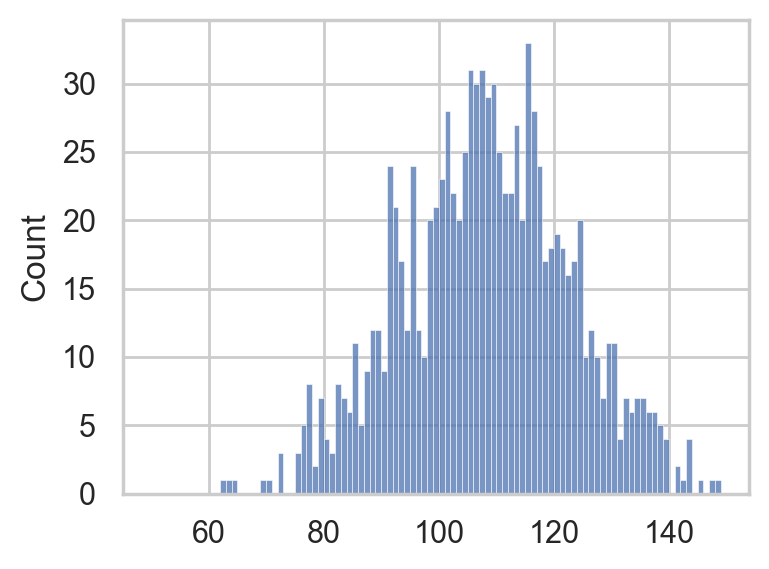

In [4]:
import numpy as np
np.random.seed(43)

N = 1000
population = rvX.rvs(N)

sns.histplot(population, bins=range(50,150,1))

savefig(plt.gcf(), "figures/histplot_iqs_pop.png");

### IQ scores sample

Consider the following dataset,
which consists of IQ scores of 30 students.
The IQ scores are recorded in the following list.

In [5]:
sample = [ 95.7, 100.1,  95.3, 100.7, 123.5, 119.4,  84.4, 109.6,
          108.7,  84.7, 111.0,  92.1, 138.4, 105.2,  97.5, 115.9,
          104.4, 105.6, 104.8, 110.8,  93.8, 106.6,  71.3, 130.6,
          125.7, 130.2, 101.2, 109.0, 103.8,  96.7]

In [6]:
n = len(sample)
n

30

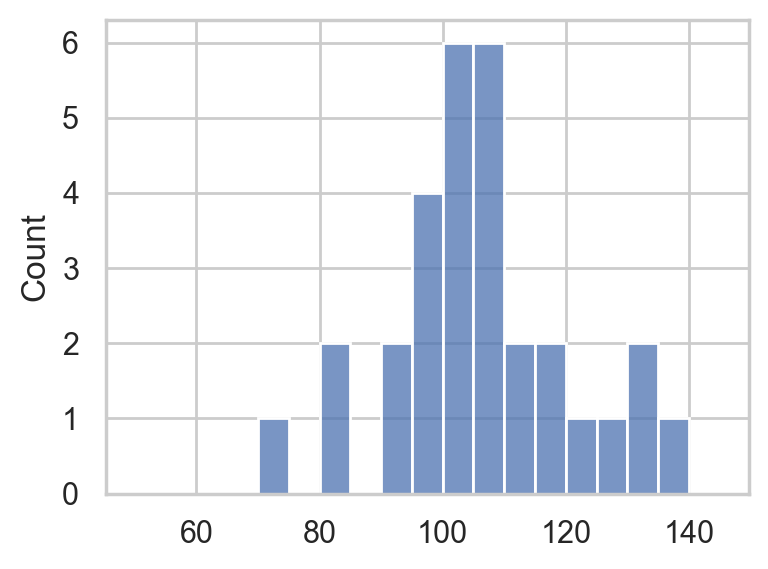

In [7]:
import seaborn as sns
sns.histplot(sample, bins=range(50,150,5));

savefig(plt.gcf(), "figures/histplot_iqs.png")

### Statistical inference tasks

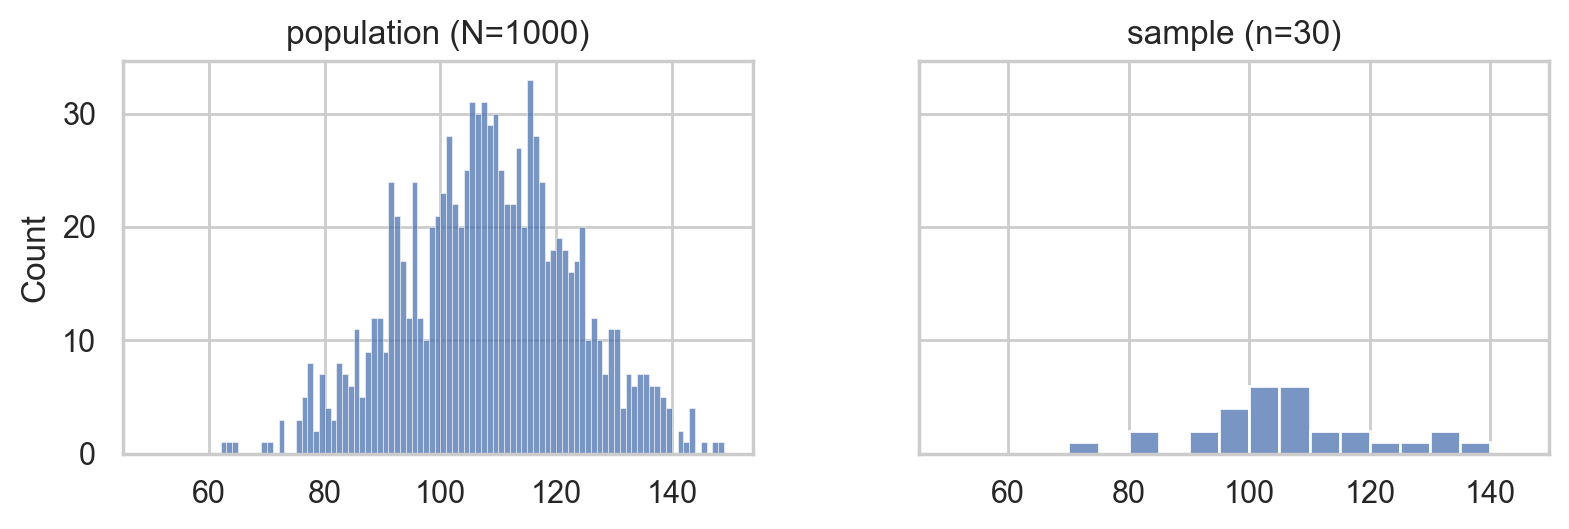

In [8]:
with plt.rc_context({"figure.figsize":(8,2.8)}):
    fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
    # population    
    sns.histplot(population, bins=np.arange(50,150,1), ax=ax1)
    ax1.set_title("population (N=1000)")
    # sample
    sns.histplot(sample, bins=range(50,150,5), ax=ax2)
    ax2.set_title("sample (n=30)")
    savefig(plt.gcf(), "figures/histplots_iqs_pop_and_sample.png", w_pad=5)

## Estimation (TASK1)

### Sample mean

In [9]:
def mean(xs):
    return sum(xs)/len(xs)

In [10]:
mean(sample)

105.89

The sample mean is an estimate for the pupulation mean $\mu$.

### Sample standard deviation

Here is another estimator,
the standard deviation $s_{\mathbf{x}} = \tt{std}(\mathbf{x}) = \sqrt{ \frac{1}{n-1}\sum_{i=1}^n (x_i-\overline{\mathbf{x}})^2 }$.

In [11]:
import numpy as np

def std(xs):
    n = len(xs)
    xbar = mean(xs)
    s2 = sum([(xi-xbar)**2 for xi in xs])
    return np.sqrt(s2 / (n-1))

In [12]:
std(sample)

14.658229417469641

The sample standard deviation is an estimate for the population standard deviation $\sigma$.

## Sampling distribution of the mean

Consider the following ten random samples from the population.

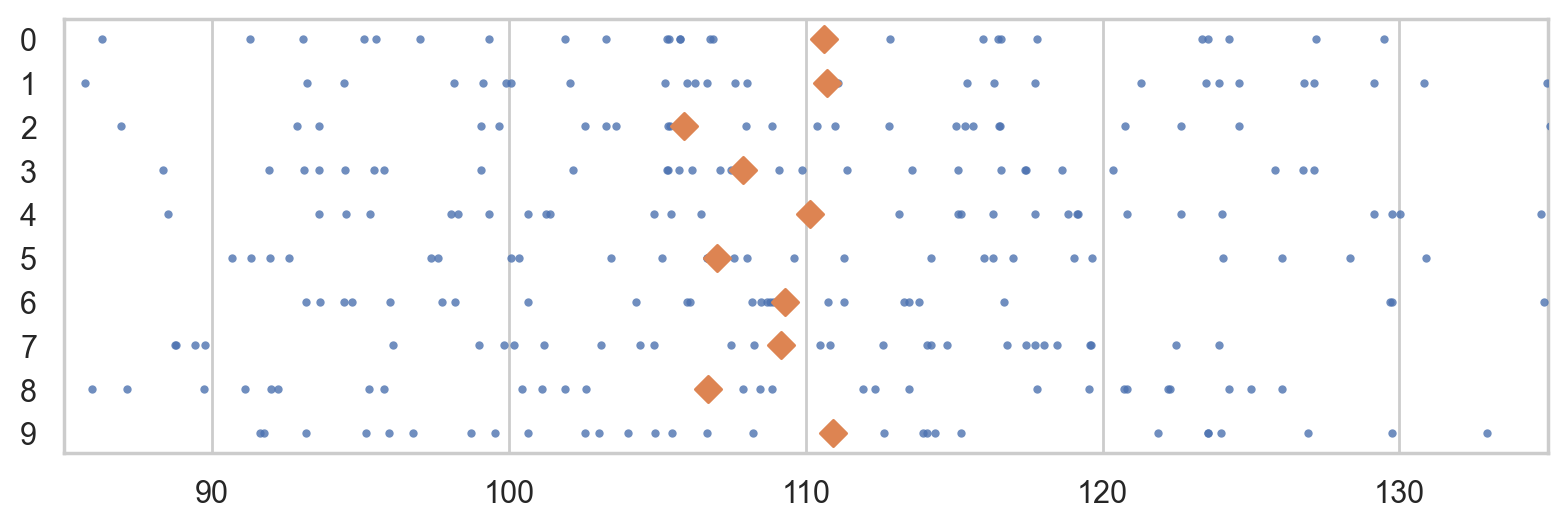

In [13]:
np.random.seed(5)

rsamples = []
for i in range(10):
    rsample = np.random.choice(population, n)
    rsamples.append(rsample)

with plt.rc_context({"figure.figsize":(8,2.8)}):
    ax = sns.stripplot(rsamples, orient="h", s=3, color="C0", alpha=0.8, jitter=0)
    ax.set_xlim([85,135])
    for i, rsample in enumerate(rsamples):
        rmean = np.mean(rsample)
        ax.scatter(rmean, i, marker="D", s=45, color="C1", zorder=10)

savefig(plt.gcf(), "figures/samples_from_population_n30.png")

Let's see the means from 5000 samples.

In [14]:
np.random.seed(6)

rmeans = []
for i in range(5000):
    rsample = np.random.choice(population, n)
    rmean = mean(rsample)
    rmeans.append(rmean)

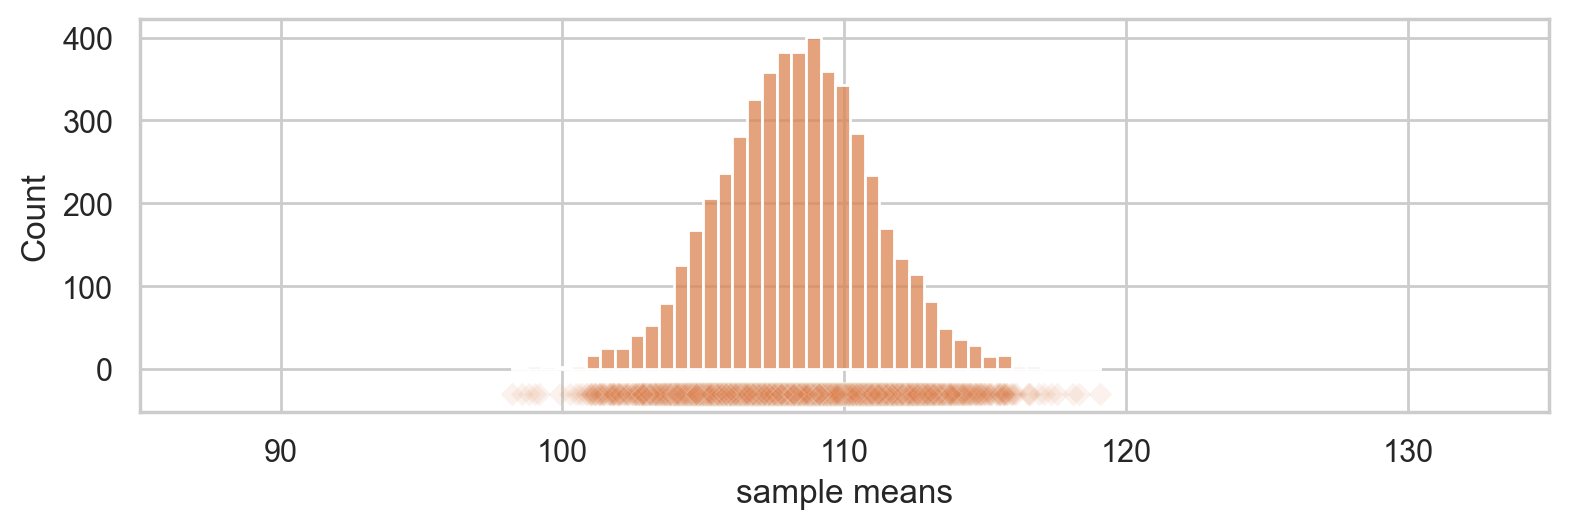

In [15]:
with plt.rc_context({"figure.figsize":(8,2.8)}):
    ax = sns.histplot(rmeans, color="C1", bins=40)
    ax.set_xlim([85,135])
    sns.scatterplot(x=rmeans, y=-30, color="C1", marker="D", alpha=0.1, ax=ax)
    ax.set_ylabel("Count")
    ax.set_xlabel("sample means")
    savefig(plt.gcf(), "figures/true_sampling_dist_mean_population_n30.png")

## Bootstrap estimation

Generate 5000 bootstrap samples (sampling with replacement) from the sample `sample`.
Use the bootstrap samples to approximate the sampling distribution of the mean.

In [16]:
np.random.seed(46)

bmeans = []
for i in range(5000):
    bsample = np.random.choice(sample, n)
    bmean = mean(bsample)
    bmeans.append(bmean)

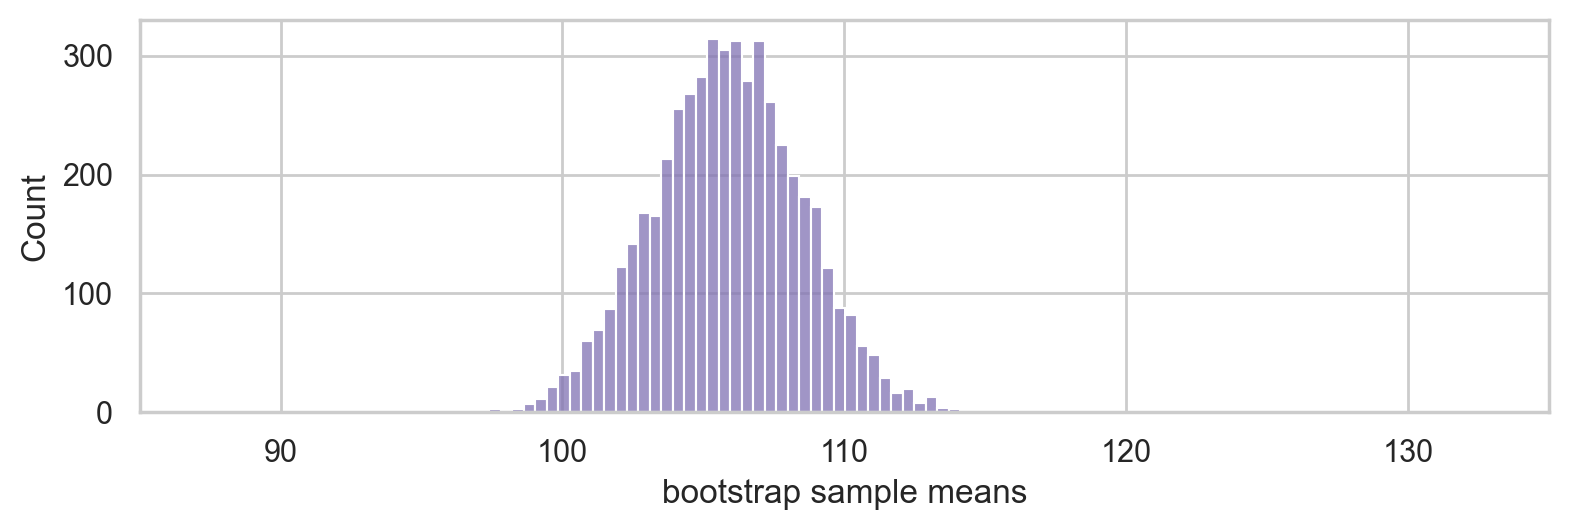

In [17]:
with plt.rc_context({"figure.figsize":(8,2.8)}):
    ax = sns.histplot(bmeans, color="C4")
    ax.set_xlim([85,135])
    ax.set_ylim([0,330])
    ax.set_ylabel("Count")
    ax.set_xlabel("bootstrap sample means")
    savefig(plt.gcf(), "figures/bootstrap_dist_mean_iqs.png")

In [18]:
ci90 = np.percentile(bmeans, [5, 95])
ci90.round(2)

array([101.52, 110.16])

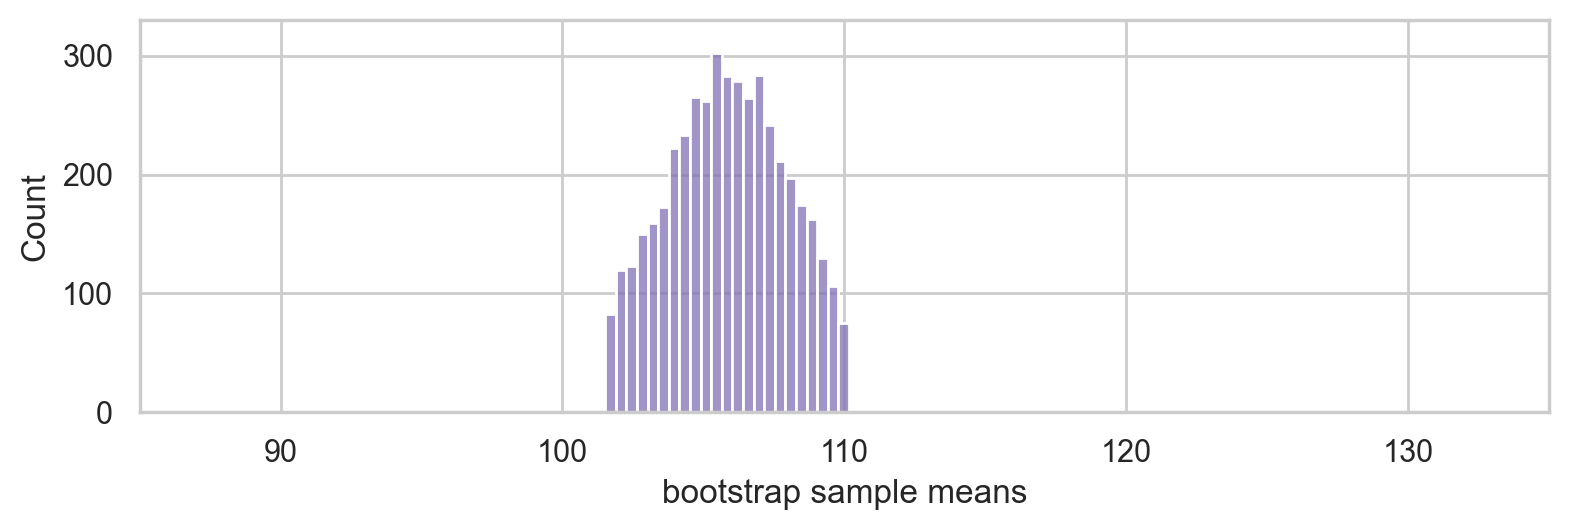

In [19]:
bulk = [x for x in bmeans if x > ci90[0] and x < ci90[1]]

with plt.rc_context({"figure.figsize":(8,2.8)}):
    ax = sns.histplot(bulk, color="C4")
    ax.set_xlim([85,135])
    ax.set_ylim([0,330])
    ax.set_ylabel("Count")
    ax.set_xlabel("bootstrap sample means")
    savefig(plt.gcf(), "figures/bootstrap_dist_mean_iqs_ci.png")

#### Alternative method: using the analytical approximation formula

The classical statistics method for computing a confidence interval
involves the following steps.

In [20]:
# 2. Compute the sample mean
xbar = mean(sample)
xbar

105.89

In [21]:
# 3. Compute the sample standard deviation 
stddev = std(sample)
stddev

14.658229417469641

In [22]:
# 4. Calculate the estimated standard error
sehat = stddev / np.sqrt(n)
sehat

2.6762143016779776

In [23]:
# 5. Lookup the 0.05 and 0.95 quantiles of Student's t-distribution with 29 degrees of freedom
from scipy.stats import t as tdist
t_l = tdist(df=29).ppf(0.05)
t_u = tdist(df=29).ppf(0.95)
t_l, t_u

(-1.6991270265334977, 1.6991270265334972)

In [24]:
# 6. Plug all of the above into the  formula
[xbar + t_l*sehat, xbar + t_u*sehat]

[101.34277195122348, 110.43722804877652]

#### Alternative 2: using a pre-defined helper function

In [25]:
from ministats import ci_mean
ci_mean(sample, alpha=0.1)

[101.34277195122348, 110.43722804877652]

In [26]:
np.random.seed(46)
from ministats import ci_mean
ci_mean(sample, alpha=0.1, method="b")

[101.51616666666666, 110.16350000000001]

In [27]:
%psource ci_mean

def ci_mean(sample, alpha=0.1, method="a"):
    """
    Compute confidence interval for the population mean.
    - method="a" analytical approx. based on Student's t-dist
    - method="b" approx. based on bootstrap estimation
    """
    assert method in ["a", "b"]
    if method == "a":        # analytical approximation
        from scipy.stats import t as tdist
        n = len(sample)
        xbar = np.mean(sample)
        sehat = np.std(sample, ddof=1) / np.sqrt(n)
        t_l = tdist(df=n-1).ppf(alpha/2)
        t_u = tdist(df=n-1).ppf(1-alpha/2)
        return [xbar + t_l*sehat, xbar + t_u*sehat]
    elif method == "b":          # bootstrap estimation
        xbars_boot = gen_boot_dist(sample, estfunc=mean)
        return [np.quantile(xbars_boot, alpha/2),
                np.quantile(xbars_boot, 1-alpha/2)]


#### Alternative 3: using scipy

In [28]:
from scipy.stats import bootstrap
bootstrap([sample], np.mean, confidence_level=0.9)

BootstrapResult(confidence_interval=ConfidenceInterval(low=101.65580265968799, high=110.3411373248789), bootstrap_distribution=array([103.30333333, 106.72666667, 100.48666667, ..., 108.34      ,
       104.98      , 105.42      ]), standard_error=2.6520006292075133)

## Conclusion

## Links

- Great talks on resampling methods:
  - [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA) talk by Jake Vanderplas
  - [There's Only One Test](https://www.youtube.com/watch?v=S41zQEshs5k) talk by Allen B. Downey
- [Python tutorial](https://nobsstats.com/tutorials/python_tutorial.html)
- Previous blog posts:
  - [Outline of the stats curriculum research](https://minireference.com/blog/fixing-the-introductory-statistics-curriculum/)
  - [Book proposal](https://minireference.com/blog/no-bullshit-guide-to-statistics-progress-update/)
  - [Stats survey results](https://minireference.com/blog/what-stats-do-people-want-to-learn/)
  - [Python coding skills for statistics](https://minireference.com/blog/python-for-stats/)
- Book website [noBSstats.com](https://nobsstats.com/intro.html): contains all the notebooks, demos, and visualizations from the book.

<!-- 
- [Detailed book outline](https://docs.google.com/document/d/1fwep23-95U-w1QMPU31nOvUnUXE2X3s_Dbk5JuLlKAY/edit): continuously updated list of the topics that are covered in each section.
- [Pandas tutorial](https://nobsstats.com/tutorials/pandas_tutorial.html)
- [Seaborn tutorial](https://nobsstats.com/tutorials/seaborn_tutorial.html)
-->


## CUT MATERIAL

In [29]:
%pip install --quiet qrcode


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


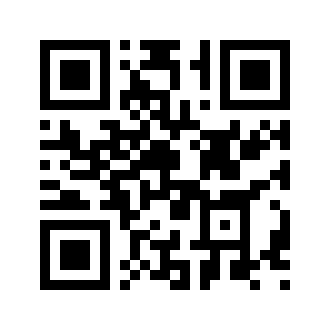

In [30]:
import qrcode
img = qrcode.make('https://is.gd/MP111')
img.save("figures/QRcode_is_gd_MP111.png")
img

### Statistical inference by eyeball

Move the sliders to choose the model parameters that best match the data.

In [31]:
import numpy as np
from scipy.stats import norm
from ipywidgets import interact

def plot_pop_and_sample(mu, sigma):
    # 1. Plot histogram of sample
    ax = sns.histplot(x=sample, stat="density", bins=range(50,150,5), label="data")
    # 2. Plot probability density function of population model
    rvX = norm(mu, sigma)
    xs = np.linspace(50, 150, 1000)
    fXs = rvX.pdf(xs)
    sns.lineplot(x=xs, y=fXs, ax=ax, c="C0", label="model")
    print(f"current population model guess: X ~ N(mu={mu}, sigma={sigma})")

interact(plot_pop_and_sample, mu=(50,150,1), sigma=(3,40,1));

interactive(children=(IntSlider(value=100, description='mu', max=150, min=50), IntSlider(value=21, description…